In [25]:
import json
import math

import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [26]:
# Generate simulated data
!uv run src/sim_data_generator_optimized.py simulated_data/parameters.json

{'output_dir': 'simulated_data/', 'output_exp_file': 'simulated_scRNASeq_data.tsv', 'output_prior_file': 'simulated_prior_data.tsv', 'output_ground_truth_file': 'simulated_ground_truth.tsv', 'n_cells': 2000, 'n_genes': 2000, 'n_tfs': 200, 'ground_truth_active_inactive_prob': 0.1, 'overlap_alpha_factor': 2, 'average_number_of_targets_per_tf': 30, 'tf_effect_factor': 1.25, 'missing_percentage': 0, 'random_seed': 8, 'distribution_type': 'negative_binomial'}
Generating prior data (Poisson targets)...
Generating gene expression data...
Generating gene expression data...
Zero percentage before dropout: 0.706075
No additional dropout applied.
Wrote prior to simulated_prior_data.tsv
Wrote ground truth to simulated_ground_truth.tsv
Wrote gene expression to simulated_scRNASeq_data.tsv


In [460]:
# # Plot stats of data
# def plot_hist_with_stats(data, ax, title, bins=90, color='red'):
#     sns.histplot(data, bins=bins, ax=ax, color=color, kde=True)
#     ax.set_title(title)
#     ax.set_xlabel('')
#     ax.set_ylabel('Count')
#
#     mean_val = np.mean(data)
#     median_val = np.median(data)
#     min_val = np.min(data)
#     max_val = np.max(data)
#
#     # Draw vertical lines
#     ax.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean = {mean_val:.3f}')
#     ax.axvline(median_val, color='green', linestyle='--', linewidth=1, label=f'Median = {median_val:.3f}')
#     ax.axvline(min_val, color='gray', linestyle=':', linewidth=1, label=f'Min = {min_val:.3f}')
#     ax.axvline(max_val, color='black', linestyle=':', linewidth=1, label=f'Max = {max_val:.3f}')
#
#     ax.legend(fontsize=8)
#
# # Calculate stats
# !uv run src/calculate_stat.py simulated_data/simulated_scRNASeq_data.tsv simulated_data/simulated_scRNASeq_data_stats.tsv
#
#
# stat_file = "simulated_data/simulated_scRNASeq_data_stats.tsv"
# stat_df = pd.read_csv(stat_file, sep="\t", index_col=0)
#
# # Some genes have all zero values. So the plot looks weird.
# fig, axs = plt.subplots(2, 3, figsize=(15, 10))
#
# plot_hist_with_stats(stat_df['mean_log'], axs[0, 0], 'Mean Distribution')
# plot_hist_with_stats(stat_df['std_log'], axs[0, 1], 'Standard Deviation Distribution')
# plot_hist_with_stats(stat_df['missing_ratio'], axs[0, 2], 'Missing Ratio Distribution')
# plot_hist_with_stats(stat_df['median_log'], axs[1, 0], 'Median Distribution')
# plot_hist_with_stats(stat_df['n_nonzero'], axs[1, 1], 'Non-zero Count Distribution')
#
# # Remove the last empty subplot
# fig.delaxes(axs[1, 2])
#
# plt.tight_layout()
# plt.show()

In [33]:
# Run kale without ignoring zeros
!uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores.tsv --pvalue_output_file simulated_data/_kale_pvalues.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted False

Using raw gene expression as input for per-cell ranking...
Starting TF activity using 8 cores.
Running in parallel with CORES_USED=8.
Processing cells in parallel: 100%|███████████| 100/100 [00:01<00:00, 86.02it/s]
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished

Aggregating results...
kale completed
Kale TF activity scores and p-values have been saved.


In [462]:
# Run kale with ignoring zeros
!uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_ignore_zeros.tsv --pvalue_output_file simulated_data/_kale_pvalues_ignore_zeros.tsv --ignore_zeros True --cores 8 --method rank_of_ranks

Not Weighted method selected; converting all weights to 1 or -1.
Using raw gene expression as input for per-cell ranking...
-> Using UNWEIGHTED mean rank calculation.
Starting TF activity using 8 cores.
Running in parallel with CORES_USED=8.
Processing cells in parallel: 100%|███████| 5500/5500 [00:04<00:00, 1196.57it/s]
[Parallel(n_jobs=8)]: Done 5500 out of 5500 | elapsed:    5.1s finished

Aggregating results...
kale completed
Kale TF activity scores and p-values have been saved.


In [463]:
# Gene Expression data
gene_exp_file = "simulated_data/simulated_scRNASeq_data.tsv"

gene_exp = pd.read_csv(gene_exp_file, sep="\t", index_col=0)
adata = sc.AnnData(gene_exp)
adata

AnnData object with n_obs × n_vars = 5500 × 4500

In [34]:
# Prior Knowledge Network
net_file = "simulated_data/simulated_prior_data.tsv"

effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}

net = pd.read_csv(
    net_file,
    sep="\t",
    names=["source", "weight", "target"],
    usecols=[0, 1, 2],
    converters={"weight": effect_map.get}
)[["source", "target", "weight"]]

net.head()

,source,target,weight
0,TF_1,G_52,1
1,TF_1,G_41,-1
2,TF_1,G_60,1
3,TF_1,G_54,-1
4,TF_1,G_64,-1


### Plot stats of prior knowledge network

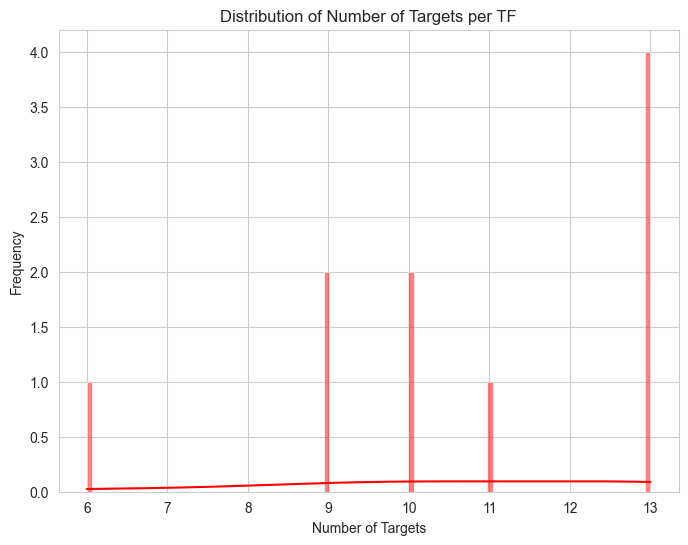

In [35]:
# group the net by source and count the number of targets
net_grouped = net.groupby("source").size().reset_index(name="num_targets")
# Plot histogram of num_targets
plt.figure(figsize=(8, 6))
sns.histplot(net_grouped["num_targets"], bins=100, kde=True, color='red')
plt.title("Distribution of Number of Targets per TF")
plt.xlabel("Number of Targets")
plt.ylabel("Frequency")
plt.show()

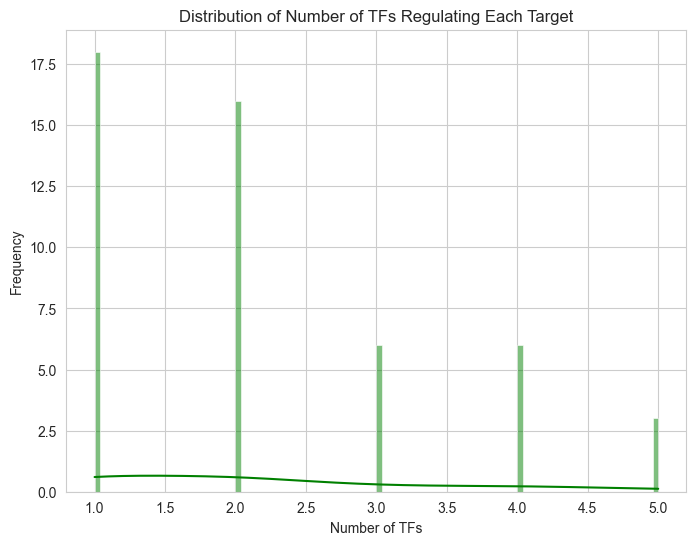

In [36]:
# Count for each target, how many TFs regulate it
target_grouped = net.groupby("target").size().reset_index(name="num_tfs")

# Plot histogram of num_tfs
plt.figure(figsize=(8, 6))
sns.histplot(target_grouped["num_tfs"], bins=100, kde=True, color='green')
plt.title("Distribution of Number of TFs Regulating Each Target")
plt.xlabel("Number of TFs")
plt.ylabel("Frequency")
plt.show()

In [38]:
target_grouped = net.groupby("target").agg(
    num_tfs=("source", "nunique")
).reset_index()
target_grouped

,target,num_tfs
0,G_1,1
1,G_10,2
2,G_12,2
3,G_19,1
4,G_20,3
5,G_22,2
6,G_26,4
7,G_27,1
8,G_28,1
9,G_3,3


In [452]:
# # Calculate the overalap between top 5 TFs with most targets i.e each first 5 TFs to each other
# top_tfs = net_grouped.sort_values(by="source", ascending=False).head(10)
#
# overlaps = []
# for i in range(len(top_tfs)):
#     for j in range(i + 1, len(top_tfs)):
#         tf1 = top_tfs.iloc[i]
#         tf2 = top_tfs.iloc[j]
#         targets_tf1 = set(net[net["source"] == tf1["source"]]["target"])
#         targets_tf2 = set(net[net["source"] == tf2["source"]]["target"])
#         overlap = targets_tf1.intersection(targets_tf2)
#         print(f"{tf1['source']}: {tf1['num_targets']} targets, \t {tf2['source']}: {tf2['num_targets']} targets.")
#         print(f"\t No. of overlapping targets: {len(overlap)} ...............")
#         overlaps.append(len(overlap))
#
# print("-----")
# print("Average overlap among top 5 TFs:", np.mean(overlaps))

In [453]:
# net_grouped

In [454]:
# # Prior Knowledge Network
# net_file = "data/causal_priors.tsv"
#
# effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}
#
# net = pd.read_csv(
#     net_file,
#     sep="\t",
#     names=["source", "weight", "target"],
#     usecols=[0, 1, 2],
#     converters={"weight": effect_map.get}
# )[["source", "target", "weight"]]
#
# net.head()
#
# # group the net by source and count number of targets
# net_grouped = net.groupby("source").size().reset_index(name="num_targets")
# # Plot histogram of num_targets
# plt.figure(figsize=(8, 6))
# sns.histplot(net_grouped["num_targets"], bins=100, kde=True, color='red')
# plt.title("Distribution of Number of Targets per TF")
# plt.xlabel("Number of Targets")
# plt.ylabel("Frequency")
# plt.show()

### Ground Truths and ROC Curve

In [29]:
# Ground Truths
ground_truths_file = "simulated_data/simulated_ground_truth.tsv"

ground_truths = pd.read_csv(ground_truths_file, sep="\t", index_col=0)
ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
ground_truths = ground_truths[["Cell_TF", "Value"]]

print(f"Ground truths shape: {ground_truths.shape}")
print(ground_truths.head(10))

Ground truths shape: (400000, 2)
        Cell_TF  Value
0   Cell_1_TF_1     -1
1   Cell_2_TF_1      0
2   Cell_3_TF_1      1
3   Cell_4_TF_1      0
4   Cell_5_TF_1      0
5   Cell_6_TF_1      0
6   Cell_7_TF_1      0
7   Cell_8_TF_1      0
8   Cell_9_TF_1      0
9  Cell_10_TF_1      0


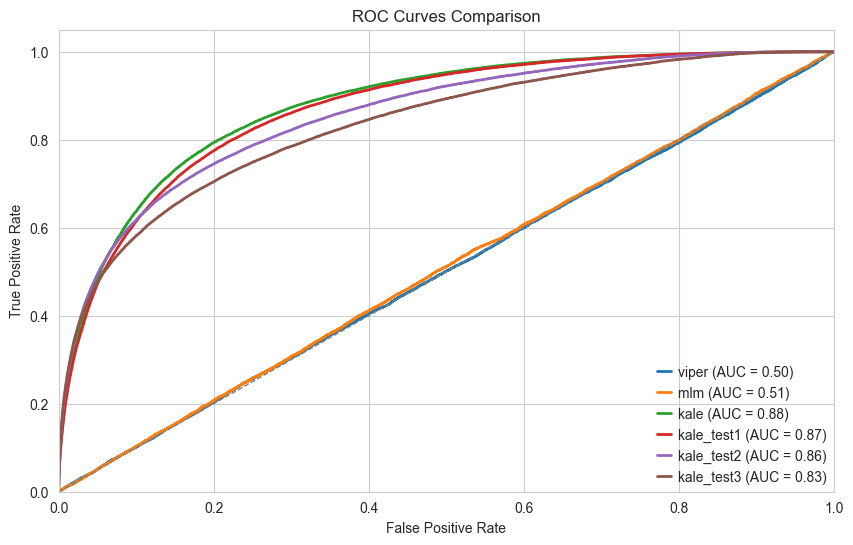

In [30]:
methods_to_run = ["viper", "mlm"]
dc.mt.decouple(adata, net, tmin=1, methods=methods_to_run)

plt.figure(figsize=(10, 6))

methods_to_run.append("kale")
methods_to_run.append("kale_test1")
methods_to_run.append("kale_test2")
methods_to_run.append("kale_test3")

for method in methods_to_run:
    if method == "kale":
        method_scores = pd.read_csv("simulated_data/_kale_scores_test1.tsv", sep="\t", index_col=0)
    elif method == "kale_test1":
        method_scores = pd.read_csv("simulated_data/_kale_scores_test2.tsv", sep="\t", index_col=0)
    elif method == "kale_test2":
        method_scores = pd.read_csv("simulated_data/_kale_scores_test3.tsv", sep="\t", index_col=0)
    elif method == "kale_test3":
        method_scores = pd.read_csv("simulated_data/_kale_scores_test4.tsv", sep="\t", index_col=0)
    else:
        # Get the scores for the current method
        method_scores = adata.obsm[f"score_{method}"]

    # Melt the DataFrame to long format
    scores_out = method_scores.reset_index().rename(columns={"index": "Cell"})
    scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
    scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
    scores_out = scores_out[["Cell_TF", "Value"]]

    # Merge with ground truths
    scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

    # Sort by Cell_TF to ensure consistent ordering
    scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
    scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{method} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.show()

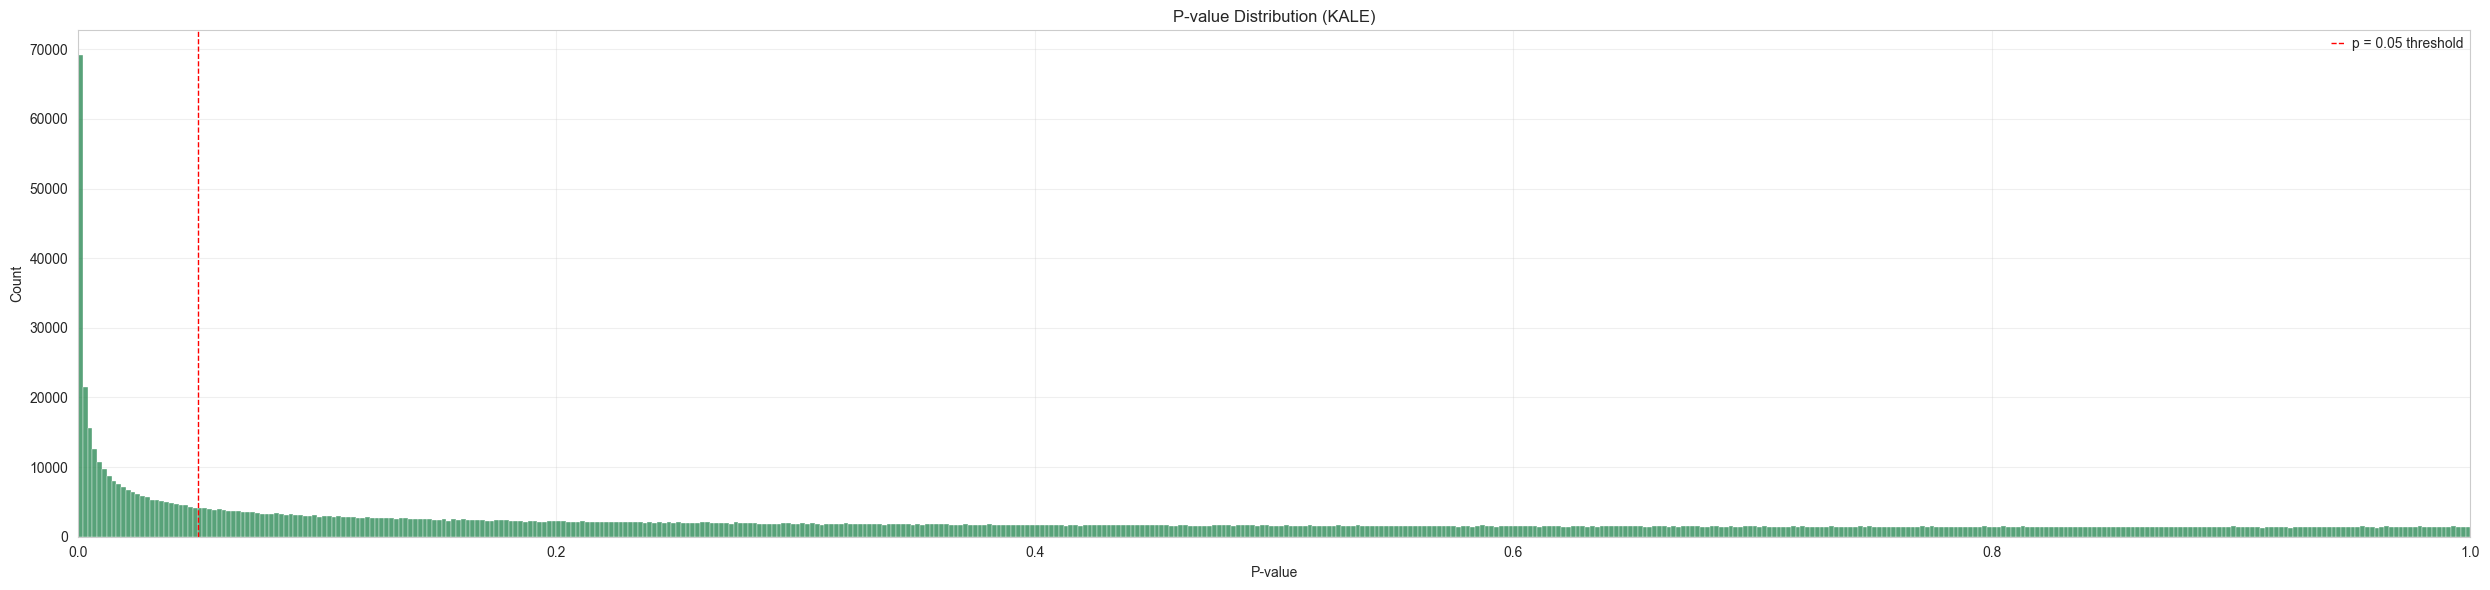

In [184]:
# Load
pvalues = pd.read_csv("simulated_data/_kale_pvalues.tsv", sep="\t", index_col=0)

flat_p = pvalues.values.flatten()

# Plot
plt.figure(figsize=(25, 6))
sns.histplot(flat_p, bins=500, color='seagreen', alpha=0.8, kde=False)
plt.axvline(0.05, color='red', linestyle='--', linewidth=1, label='p = 0.05 threshold')

# Labels
plt.title("P-value Distribution (KALE)")
plt.xlabel("P-value")
plt.ylabel("Count")
plt.xlim(0, 1)
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

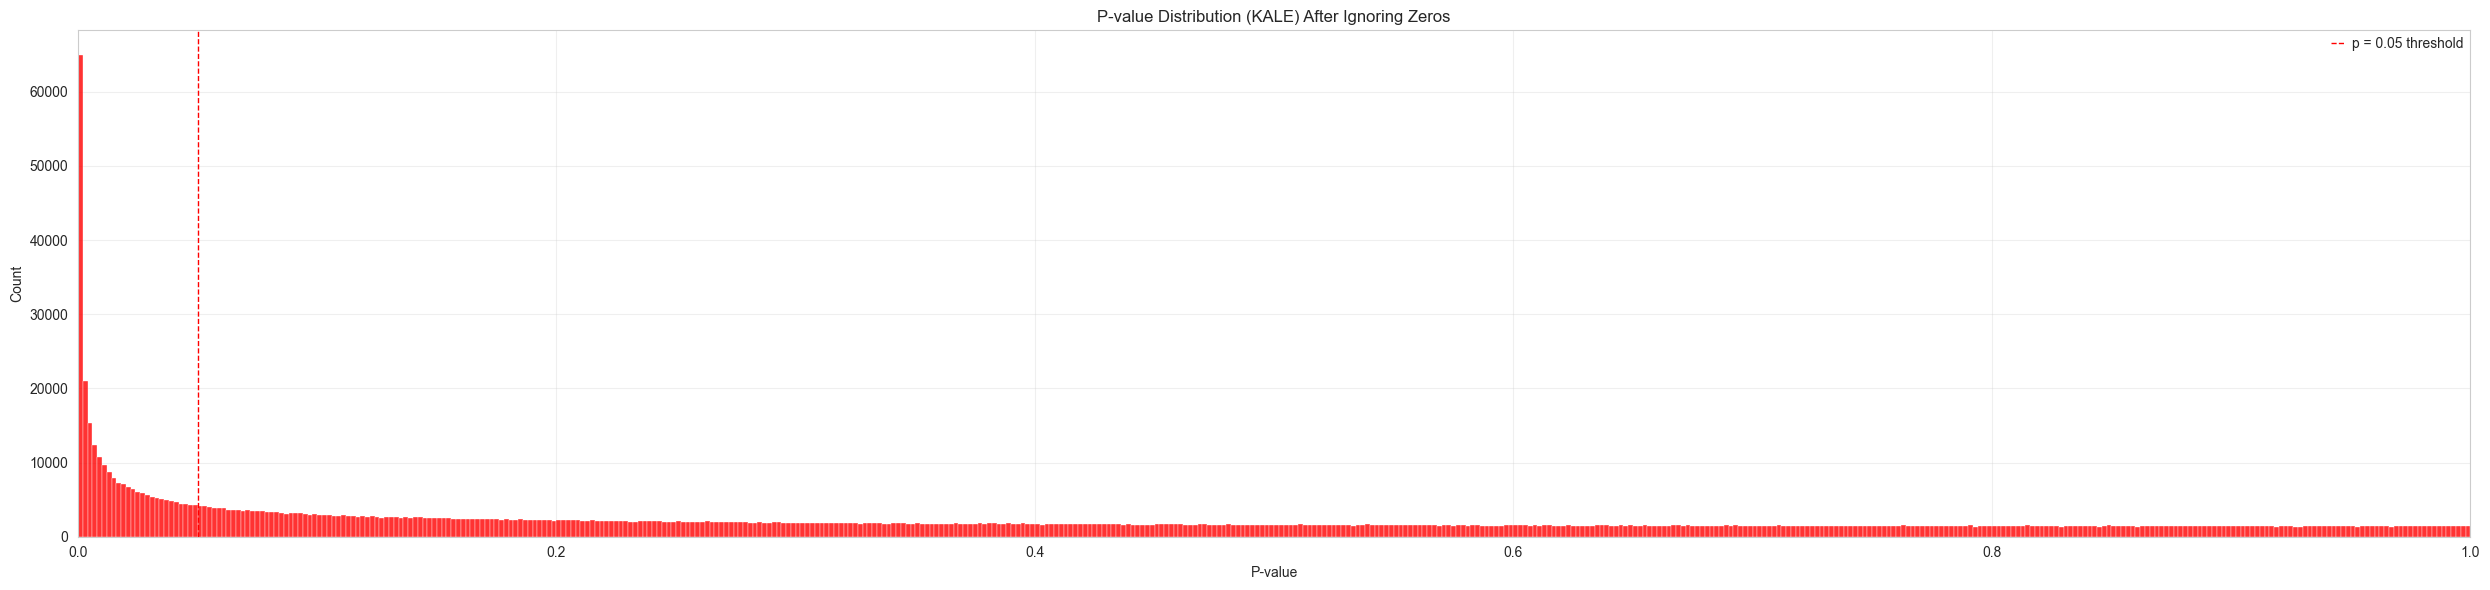

In [185]:
# Load
pvalues = pd.read_csv("simulated_data/_kale_pvalues_ignore_zeros.tsv", sep="\t", index_col=0)

flat_p = pvalues.values.flatten()

# Plot
plt.figure(figsize=(25, 6))
sns.histplot(flat_p, bins=500, color='red', alpha=0.8, kde=False)
plt.axvline(0.05, color='red', linestyle='--', linewidth=1, label='p = 0.05 threshold')

# Labels
plt.title("P-value Distribution (KALE) After Ignoring Zeros")
plt.xlabel("P-value")
plt.ylabel("Count")
plt.xlim(0, 1)
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Plot pvalue cummulative distribution

In [965]:
# Running methods Pipeline
# 1. Generate simulated data
!uv run src/sim_data_generator_optimized.py simulated_data/parameters.json

# 2. Run kale without ignoring zeros
!uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores.tsv --pvalue_output_file simulated_data/_kale_pvalues.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted False

# 3. Run kale with ignoring zeros
!uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_ignore_zeros.tsv --pvalue_output_file simulated_data/_kale_pvalues_ignore_zeros.tsv --ignore_zeros True --cores 8 --method rank_of_ranks

# 4. Gene Expression data
gene_exp_file = "simulated_data/simulated_scRNASeq_data.tsv"
gene_exp = pd.read_csv(gene_exp_file, sep="\t", index_col=0)
adata = sc.AnnData(gene_exp)

# 5. Prior Knowledge Network
net_file = "simulated_data/simulated_prior_data.tsv"
effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}
net = pd.read_csv(
    net_file,
    sep="\t",
    names=["source", "weight", "target"],
    usecols=[0, 1, 2],
    converters={"weight": effect_map.get}
)[["source", "target", "weight"]]

# 6. Ground Truths
ground_truths_file = "simulated_data/simulated_ground_truth.tsv"
ground_truths = pd.read_csv(ground_truths_file, sep="\t", index_col=0)
ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
ground_truths = ground_truths[["Cell_TF", "Value"]]

# 7. Other methods
methods_to_run = ["viper", "mlm"]
dc.mt.decouple(adata, net, tmin=1, methods=methods_to_run)

# 8. ROC Curve plotting
methods_to_run.append("kale")
methods_to_run.append("kale_ignore_zeros")
for method in methods_to_run:
    if method == "kale":
        method_scores = pd.read_csv("simulated_data/_kale_scores.tsv", sep="\t", index_col=0)
    elif method == "kale_ignore_zeros":
        method_scores = pd.read_csv("simulated_data/_kale_scores_ignore_zeros.tsv", sep="\t", index_col=0)
    else:
        # Get the scores for the current method
        method_scores = adata.obsm[f"score_{method}"]

    # Melt the DataFrame to long format
    scores_out = method_scores.reset_index().rename(columns={"index": "Cell"})
    scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
    scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
    scores_out = scores_out[["Cell_TF", "Value"]]

    # Merge with ground truths
    scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

    # Sort by Cell_TF to ensure consistent ordering
    scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
    scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
    roc_auc = auc(fpr, tpr)
    print(f"{method} AUC: {roc_auc:.4f}")


NameError: name 'End' is not defined

## parameters.json test suite

In [4]:
final_result = []
test_suite = []
prior_pairwise_overlap_stats = {}


alpha_values = [0, 2, 4]
average_targets = [30, 50]


for alpha in alpha_values:
    for avg_targets in average_targets:
        test_case = {
            "output_dir": "simulated_data/",
            "output_exp_file": "simulated_scRNASeq_data.tsv",
            "output_prior_file": "simulated_prior_data.tsv",
            "output_ground_truth_file": "simulated_ground_truth.tsv",
            "n_cells": 1000,
            "n_genes": 1000,
            "n_tfs": 100,
            "ground_truth_active_inactive_prob": 0.1,
            "overlap_alpha_factor": alpha,
            "average_number_of_targets_per_tf": avg_targets,
            "tf_effect_factor": 1.25,
            "missing_percentage": 0,
            "random_seed": 28,
            "distribution_type": "negative_binomial"
        }
        test_suite.append(test_case)

for i, test_case in enumerate(test_suite):
    with open("simulated_data/parameters.json", "w") as f:
        json.dump(test_case, f, indent=4)


    # 1. Generate simulated data
    print("\nGenerating simulated data for test case", i + 1)
    !uv run src/sim_data_generator_optimized.py simulated_data/parameters.json


    # 2. Run kale without
    print("\nRunning KALE for test case", i + 1)
    !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores.tsv --pvalue_output_file simulated_data/_kale_pvalues.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted False


    # 2.1 Run with a weighted option 1
    print("\nRunning KALE with weights for test case", i + 1)
    !uv run src/kale_archive.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_weighted_option1.tsv --pvalue_output_file simulated_data/_kale_pvalues_weighted_option1.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted True

    # 2.2 Run with a weighted option 2
    print("\nRunning KALE with weights for test case", i + 1)
    !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_weighted_option2.tsv --pvalue_output_file simulated_data/_kale_pvalues_weighted_option2.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --weighted True


    # # 3. Run kale with ignoring zeros
    # print("\n\nRunning KALE with ignoring zeros for test case", i + 1)
    # !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_ignore_zeros.tsv --pvalue_output_file simulated_data/_kale_pvalues_ignore_zeros.tsv --ignore_zeros True --cores 8 --method rank_of_ranks


    # 4. Gene Expression data
    gene_exp_file = "simulated_data/simulated_scRNASeq_data.tsv"
    gene_exp = pd.read_csv(gene_exp_file, sep="\t", index_col=0)
    adata = sc.AnnData(gene_exp)


    # 5. Prior Knowledge Network
    net_file = "simulated_data/simulated_prior_data.tsv"
    effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}
    net = pd.read_csv(
        net_file,
        sep="\t",
        names=["source", "weight", "target"],
        usecols=[0, 1, 2],
        converters={"weight": effect_map.get}
    )[["source", "target", "weight"]]


    # 5.1 Pairwise Overlap Stats
    unique_tfs = net['source'].unique()
    group_size = 5
    overlap_coefficient_list = []
    for p in range(0, len(unique_tfs), group_size):
        current_tfs = unique_tfs[p:p + group_size]
        overlap_coefficient = []
        for j in range(len(current_tfs)):
            for k in range(j + 1, len(current_tfs)):
                targets_tf1 = set(net[net['source'] == current_tfs[j]]['target'])
                targets_tf2 = set(net[net['source'] == current_tfs[k]]['target'])
                intersection_targets = targets_tf1.intersection(targets_tf2)
                overlap_coefficient.append(len(intersection_targets) / min(len(targets_tf1), len(targets_tf2)))
        overlap_coefficient_list.append(overlap_coefficient)
    average_groupwise_overlap_coefficient = [sum(group)/len(group) for group in overlap_coefficient_list]
    prior_pairwise_overlap_stats[
        f"{test_case['overlap_alpha_factor']}_{test_case['average_number_of_targets_per_tf']}"] = overlap_coefficient_list


    # 6. Ground Truths
    ground_truths_file = "simulated_data/simulated_ground_truth.tsv"
    ground_truths = pd.read_csv(ground_truths_file, sep="\t", index_col=0)
    ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
    ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
    ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
    ground_truths = ground_truths[["Cell_TF", "Value"]]


    # 7. Run other methods
    print("\nRunning Viper and MLM...")
    methods_to_run = ["viper", "mlm"]
    dc.mt.decouple(adata, net, tmin=1, methods=methods_to_run)


    # 8. Compute AUC for each method
    print("Computing AUC for each method...")
    methods_to_run.append("kale")
    methods_to_run.append("weighted_kale_option1")
    methods_to_run.append("weighted_kale_option2")
    # methods_to_run.append("kale_ignore_zeros")


    for method in methods_to_run:
        if method == "kale":
            method_scores = pd.read_csv("simulated_data/_kale_scores.tsv", sep="\t", index_col=0)
        # elif method == "kale_ignore_zeros":
        #     method_scores = pd.read_csv("simulated_data/_kale_scores_ignore_zeros.tsv", sep="\t", index_col=0)
        elif method == "weighted_kale_option1":
            method_scores = pd.read_csv("simulated_data/_kale_scores_weighted_option1.tsv", sep="\t", index_col=0)
        elif method == "weighted_kale_option2":
            method_scores = pd.read_csv("simulated_data/_kale_scores_weighted_option2.tsv", sep="\t", index_col=0)
        else:
            method_scores = adata.obsm[f"score_{method}"]

        ##### Missing Check #####
        missing_count = method_scores.isnull().sum().sum()
        if missing_count > 0:
            print("*" * 150 + " ," + method)
            print(f"Warning: {missing_count} missing values found in {method} scores. Filling with 0.")
            method_scores = method_scores.fillna(0)
            # Find row and column indexes with missing values
            missing_rows, missing_cols = np.where(method_scores.isnull())
            for row, col in zip(missing_rows, missing_cols):
                print(f"Missing value at row {method_scores.index[row]}, column {method_scores.columns[col]}")
            print("*" * 150)
        #########################

        # Melt the DataFrame to long format
        scores_out = method_scores.reset_index().rename(columns={"index": "Cell"})
        scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
        scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
        scores_out = scores_out[["Cell_TF", "Value"]]

        # Merge with ground truths
        scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

        # Sort by Cell_TF to ensure consistent ordering
        scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
        scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
        roc_auc = auc(fpr, tpr)

        # collect AUC results
        test_case["auc_" + method] = roc_auc

    final_result.append(test_case)


# 8. Save final results to a CSV file
final_result_df = pd.DataFrame(final_result)
final_result_df.drop(
    ['output_dir', 'output_exp_file', 'output_prior_file', 'output_ground_truth_file', 'distribution_type'], axis=1,
    inplace=True)
final_result_df.to_csv("simulated_data/simulation_test_suite_results_with_overlap_k_5_overlap_coefficient.tsv", index=False, sep="\t")


# 9. Save prior pairwise overlap stats in tsv
overlap_stats_df = pd.DataFrame(prior_pairwise_overlap_stats)
overlap_stats_df.to_csv("simulated_data/pairwise_overlap_histogram_k_5_overlap_coefficient.tsv", index=False, sep="\t")



Generating simulated data for test case 1
{'output_dir': 'simulated_data/', 'output_exp_file': 'simulated_scRNASeq_data.tsv', 'output_prior_file': 'simulated_prior_data.tsv', 'output_ground_truth_file': 'simulated_ground_truth.tsv', 'n_cells': 1000, 'n_genes': 1000, 'n_tfs': 100, 'ground_truth_active_inactive_prob': 0.1, 'overlap_alpha_factor': 0, 'average_number_of_targets_per_tf': 30, 'tf_effect_factor': 1.25, 'missing_percentage': 0, 'random_seed': 28, 'distribution_type': 'negative_binomial'}
Generating prior data (Poisson targets)...
Generating gene expression data...
Generating gene expression data...
Zero percentage before dropout: 0.1488
No additional dropout applied.
Wrote prior to simulated_prior_data.tsv
Wrote ground truth to simulated_ground_truth.tsv
Wrote gene expression to simulated_scRNASeq_data.tsv

Running KALE for test case 1
Using raw gene expression as input for per-cell ranking...
Starting TF activity using 8 cores.
Running in parallel with CORES_USED=8.
Processi

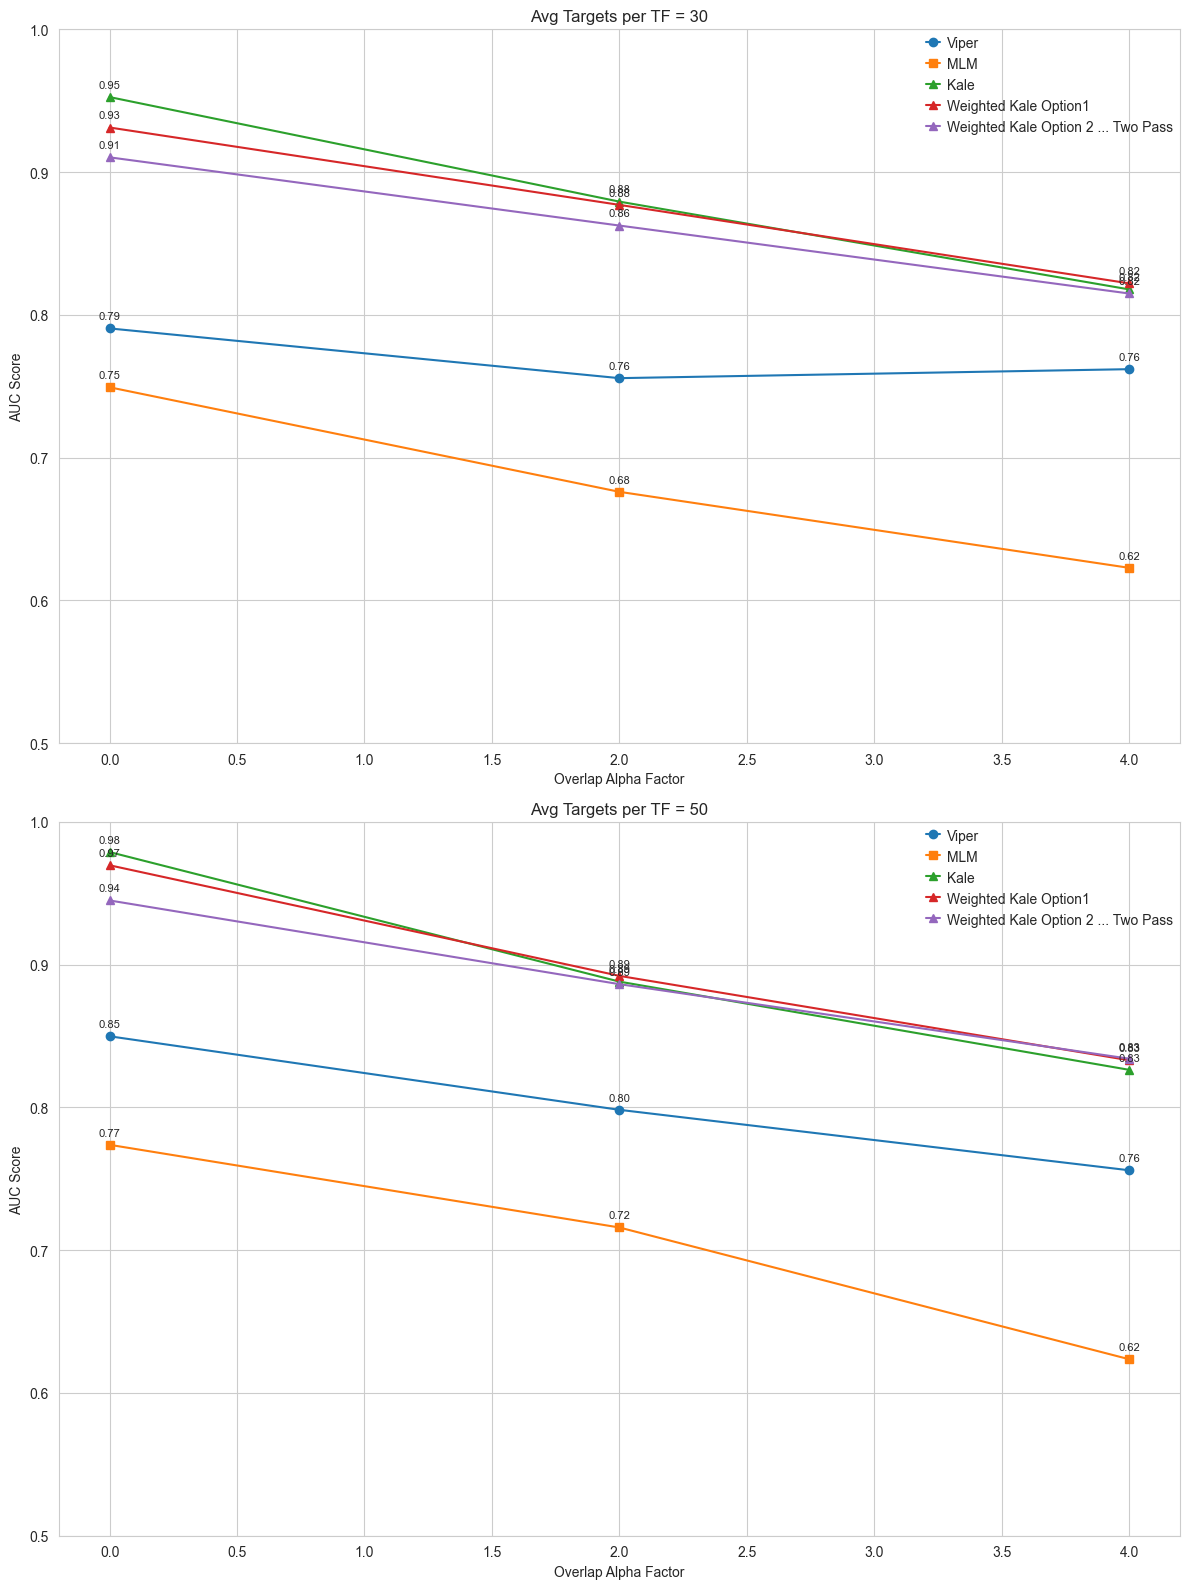

In [5]:
# Load data
final_result_df = pd.read_csv(
    "simulated_data/simulation_test_suite_results_with_overlap_k_5_overlap_coefficient.tsv",
    sep="\t"
)
# Unique target counts
unique_targets = sorted(final_result_df['average_number_of_targets_per_tf'].unique())

# Setup figure
fig, axes = plt.subplots(len(unique_targets), 1, figsize=(12, 8 * len(unique_targets)))
if len(unique_targets) == 1:
    axes = [axes]

# Plot
for i, n_targets in enumerate(unique_targets):
    ax = axes[i]
    n_targets_results = final_result_df[final_result_df['average_number_of_targets_per_tf'] == n_targets]

    alpha_values = sorted(n_targets_results['overlap_alpha_factor'].unique())

    ax.plot(alpha_values, n_targets_results['auc_viper'], marker='o', label='Viper')
    ax.plot(alpha_values, n_targets_results['auc_mlm'], marker='s', label='MLM')
    ax.plot(alpha_values, n_targets_results['auc_kale'], marker='^', label='Kale')
    ax.plot(alpha_values, n_targets_results['auc_weighted_kale_option1'], marker='^', label='Weighted Kale Option1')
    ax.plot(alpha_values, n_targets_results['auc_weighted_kale_option2'], marker='^', label='Weighted Kale Option 2 ... Two Pass')

    for col, label in [('auc_viper', 'Viper AUC'), ('auc_mlm', 'MLM AUC'), ('auc_kale', 'Kale AUC'), ('auc_weighted_kale_option1', 'Weighted Kale AUC option1'), ('auc_weighted_kale_option2', 'Weighted Kale AUC option Two pass')]:
        for x, y in zip(alpha_values, n_targets_results[col]):
            ax.text(x, y + 0.005, f'{y:.2f}', ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Overlap Alpha Factor')
    ax.set_ylabel('AUC Score')
    ax.set_title(f'Avg Targets per TF = {n_targets}')
    ax.set_ylim(0.5, 1)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [5]:
overlap_stats_df

,0_30,0_50,2_30,2_50,5_30,5_50
0,"[0.08571428571428572, 0.029411764705882353, 0....","[0.03571428571428571, 0.03571428571428571, 0.0...","[0.5142857142857142, 0.5294117647058824, 0.608...","[0.6428571428571429, 0.5357142857142857, 0.634...","[0.9428571428571428, 0.9705882352941176, 0.956...","[0.9464285714285714, 0.9107142857142857, 0.951..."
1,"[0.0, 0.03225806451612903, 0.03125, 0.0625, 0....","[0.061224489795918366, 0.058823529411764705, 0...","[0.41379310344827586, 0.6774193548387096, 0.62...","[0.5306122448979592, 0.49019607843137253, 0.49...","[0.9310344827586207, 0.9032258064516129, 0.968...","[0.9183673469387755, 0.9411764705882353, 0.962..."
2,"[0.034482758620689655, 0.043478260869565216, 0...","[0.061224489795918366, 0.07142857142857142, 0....","[0.6896551724137931, 0.782608695652174, 0.6296...","[0.5918367346938775, 0.6428571428571429, 0.652...","[1.0, 1.0, 0.9629629629629629, 0.9655172413793...","[0.9591836734693877, 0.9523809523809523, 0.978..."
3,"[0.0, 0.0, 0.08695652173913043, 0.0, 0.0, 0.12...","[0.12195121951219512, 0.04878048780487805, 0.0...","[0.43478260869565216, 0.5217391304347826, 0.52...","[0.4878048780487805, 0.5853658536585366, 0.512...","[0.9130434782608695, 0.9130434782608695, 1.0, ...","[0.926829268292683, 0.9512195121951219, 1.0, 1..."
4,"[0.04, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.060606...","[0.046511627906976744, 0.09259259259259259, 0....","[0.48, 0.5151515151515151, 0.5151515151515151,...","[0.5813953488372093, 0.5555555555555556, 0.555...","[0.96, 0.9393939393939394, 0.9090909090909091,...","[0.9767441860465116, 0.9629629629629629, 0.925..."
5,"[0.0, 0.0, 0.0, 0.0, 0.06451612903225806, 0.0,...","[0.07317073170731707, 0.0975609756097561, 0.02...","[0.5652173913043478, 0.34782608695652173, 0.69...","[0.6585365853658537, 0.43902439024390244, 0.58...","[0.9565217391304348, 0.8695652173913043, 0.869...","[1.0, 0.975609756097561, 0.975609756097561, 0...."
6,"[0.08, 0.0, 0.0, 0.0, 0.0, 0.03846153846153846...","[0.06976744186046512, 0.08571428571428572, 0.0...","[0.6, 0.47368421052631576, 0.48, 0.6, 0.578947...","[0.6976744186046512, 0.5142857142857142, 0.511...","[1.0, 0.9473684210526315, 0.96, 1.0, 1.0, 1.0,...","[1.0, 0.9428571428571428, 0.8837209302325582, ..."
7,"[0.030303030303030304, 0.030303030303030304, 0...","[0.05660377358490566, 0.03773584905660377, 0.0...","[0.6363636363636364, 0.5757575757575758, 0.708...","[0.6037735849056604, 0.6226415094339622, 0.619...","[0.9696969696969697, 0.9393939393939394, 1.0, ...","[0.9622641509433962, 0.9245283018867925, 0.976..."
8,"[0.0, 0.0, 0.0, 0.034482758620689655, 0.037037...","[0.021739130434782608, 0.0, 0.0612244897959183...","[0.48148148148148145, 0.42857142857142855, 0.5...","[0.6086956521739131, 0.46808510638297873, 0.57...","[0.9259259259259259, 0.9642857142857143, 1.0, ...","[0.8913043478260869, 0.8936170212765957, 1.0, ..."
9,"[0.034482758620689655, 0.0, 0.0416666666666666...","[0.04081632653061224, 0.021739130434782608, 0....","[0.5172413793103449, 0.5555555555555556, 0.583...","[0.5306122448979592, 0.5652173913043478, 0.591...","[0.896551724137931, 0.9259259259259259, 0.9583...","[0.9183673469387755, 0.9347826086956522, 0.918..."


In [6]:
average_pairwise_overlap_histogram = overlap_stats_df.apply(
    lambda col: col.map(lambda x: eval(x) if isinstance(x, str) else x)
)
average_pairwise_overlap_histogram = average_pairwise_overlap_histogram.apply(
    lambda col: col.map(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)
)
average_pairwise_overlap_histogram = average_pairwise_overlap_histogram.astype(float)
average_pairwise_overlap_histogram

,0_30,0_50,2_30,2_50,5_30,5_50
0,0.046907,0.064519,0.567852,0.593401,0.951602,0.963223
1,0.026171,0.047044,0.558382,0.581570,0.967054,0.927819
2,0.025804,0.062363,0.611194,0.585537,0.954389,0.935877
3,0.038430,0.044211,0.575888,0.606807,0.960446,0.970887
4,0.017509,0.057249,0.554123,0.567857,0.955340,0.945079
5,0.019355,0.065601,0.544469,0.572221,0.915910,0.955246
6,0.021524,0.074067,0.556782,0.635888,0.990737,0.960601
7,0.014756,0.047659,0.594667,0.615542,0.979272,0.964177
8,0.035406,0.049719,0.542284,0.587671,0.985317,0.959106
9,0.030460,0.037533,0.512277,0.547072,0.951740,0.935271


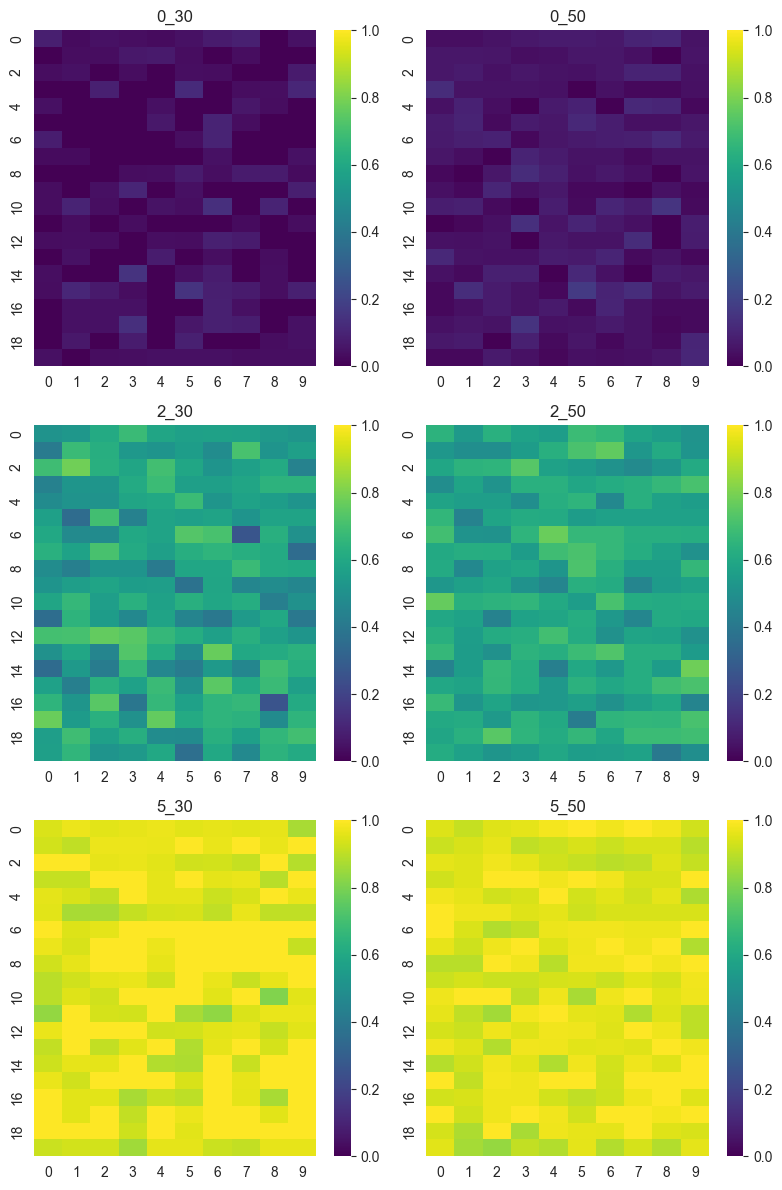

In [7]:
for col in overlap_stats_df.columns:
    overlap_stats_df[col] = overlap_stats_df[col].map(lambda x: eval(x) if isinstance(x, str) else x)

ncols = 2
nrows = int(np.ceil(len(overlap_stats_df.columns) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
axes = axes.flatten()

for i, col in enumerate(overlap_stats_df.columns):
    mat = np.vstack(overlap_stats_df[col].values)
    sns.heatmap(mat, ax=axes[i], cmap="viridis", cbar=True, vmin=0, vmax=1)
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### Create prior network with overlapped targets

In [29]:
prior_counts = {
    'TF1': 30, 'TF2': 28, 'TF3': 25, 'TF4': 26, 'TF5': 20,
    'TF6': 26, 'TF7': 29, 'TF8': 28, 'TF9': 28, 'TF10': 34,
    'TF100': 35, 'TF50': 32
}

tfs, targets, weights = [], [], []
i = 1
for tf, n in prior_counts.items():
    for _ in range(n):
        tfs.append(tf)
        targets.append(f'G{i}')
        weights.append(np.random.choice([1, -1]))
        i += 1
prior_net = pd.DataFrame({'source': tfs, 'target': targets, 'weight': weights})
print(prior_net)


prior_grouped = prior_net.groupby("source").size().reset_index(name="num_targets")
print(prior_grouped)


prior_overlapped_updated = {}
group_size = 5  # Define the size of each group to create overlaps
alpha = 4  # Overlap factor

unique_tfs = prior_net['source'].unique()

if alpha > 0:
    for i in range(0, len(unique_tfs), group_size):
        current_tfs = unique_tfs[i:i + group_size]
        current_targets = prior_net[prior_net['source'].isin(current_tfs)]['target'].unique().tolist()
        # shuffle current targets
        np.random.shuffle(current_targets)
        print(f"\n\nCurrent TFs: {current_tfs}")
        print(f"Current TFs Targets: {current_targets}")

        for tf in current_tfs:
            added_targets = prior_overlapped_updated.get(tf, [])
            original_target_count = prior_grouped[prior_grouped['source'] == tf]['num_targets'].values[0]

            mean = (len(current_targets) - 1) / 2
            std = len(current_targets) / (len(current_tfs) * alpha)

            while len(added_targets) < original_target_count:
                random_idx = int(np.random.normal(mean, std))

                if 0 <= random_idx < len(current_targets):
                    target = current_targets[random_idx]
                    if target not in added_targets:
                        added_targets.append(target)

            prior_overlapped_updated[tf] = added_targets

    print("Prior Overlapped Updated")
    print(prior_overlapped_updated)

    # Create a new prior network with overlapped targets with random weights
    new_prior_net = []
    for tf, targets in prior_overlapped_updated.items():
        for target in targets:
            weight = np.random.choice([1, -1])
            new_prior_net.append({'source': tf, 'target': target, 'weight': weight})

    new_prior_net_df = pd.DataFrame(new_prior_net)
else:
    new_prior_net_df = prior_net.copy()

print("\n\n------------------------")
print(new_prior_net_df)

    source target  weight
0      TF1     G1      -1
1      TF1     G2       1
2      TF1     G3      -1
3      TF1     G4      -1
4      TF1     G5       1
..     ...    ...     ...
336   TF50   G337       1
337   TF50   G338       1
338   TF50   G339       1
339   TF50   G340       1
340   TF50   G341      -1

[341 rows x 3 columns]
   source  num_targets
0     TF1           30
1    TF10           34
2   TF100           35
3     TF2           28
4     TF3           25
5     TF4           26
6     TF5           20
7    TF50           32
8     TF6           26
9     TF7           29
10    TF8           28
11    TF9           28


Current TFs: ['TF1' 'TF2' 'TF3' 'TF4' 'TF5']
Current TFs Targets: ['G36', 'G50', 'G102', 'G61', 'G79', 'G35', 'G27', 'G25', 'G62', 'G63', 'G31', 'G75', 'G2', 'G29', 'G70', 'G30', 'G101', 'G47', 'G111', 'G55', 'G85', 'G109', 'G42', 'G124', 'G60', 'G114', 'G53', 'G93', 'G76', 'G37', 'G20', 'G112', 'G72', 'G51', 'G120', 'G46', 'G116', 'G49', 'G105', 'G1', 'G73', '

In [30]:
net_file = "simulated_data/simulated_prior_data.tsv"
effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}
new_prior_net_df = pd.read_csv(
    net_file,
    sep="\t",
    names=["source", "weight", "target"],
    usecols=[0, 1, 2],
    converters={"weight": effect_map.get}
)[["source", "target", "weight"]]

group_size= 5


# Overlap coefficient
overlap_coefficient_list = []
tfs = new_prior_net_df['source'].unique()

for i in range(0, len(tfs), group_size):
    current_tfs = tfs[i:i + group_size]
    overlap_coefficient = []
    for j in range(len(current_tfs)):
        for k in range(j + 1, len(current_tfs)):
            targets_tf1 = set(new_prior_net_df[new_prior_net_df['source'] == current_tfs[j]]['target'])
            targets_tf2 = set(new_prior_net_df[new_prior_net_df['source'] == current_tfs[k]]['target'])
            intersection_targets = targets_tf1.intersection(targets_tf2)
            overlap_coefficient.append(len(intersection_targets) / min(len(targets_tf1), len(targets_tf2)))

    overlap_coefficient_list.append(overlap_coefficient)

print(overlap_coefficient_list)
average_groupwise_overlap_coefficient = [sum(group)/len(group) for group in overlap_coefficient_list]
print(average_groupwise_overlap_coefficient)

[[0.9464285714285714, 0.9107142857142857, 0.9512195121951219, 0.9574468085106383, 0.9821428571428571, 1.0, 0.9787234042553191, 1.0, 0.9787234042553191, 0.926829268292683], [0.9183673469387755, 0.9411764705882353, 0.9622641509433962, 0.9056603773584906, 0.9183673469387755, 0.9387755102040817, 0.9183673469387755, 0.9411764705882353, 0.9411764705882353, 0.8928571428571429], [0.9591836734693877, 0.9523809523809523, 0.9782608695652174, 0.9591836734693877, 0.9285714285714286, 0.9130434782608695, 0.8979591836734694, 0.9047619047619048, 0.9523809523809523, 0.9130434782608695], [0.926829268292683, 0.9512195121951219, 1.0, 1.0, 0.9772727272727273, 1.0, 0.9772727272727273, 0.9387755102040817, 0.9375, 1.0], [0.9767441860465116, 0.9629629629629629, 0.9259259259259259, 0.9387755102040817, 1.0, 0.9302325581395349, 0.9534883720930233, 0.9259259259259259, 0.9591836734693877, 0.8775510204081632], [1.0, 0.975609756097561, 0.975609756097561, 0.9512195121951219, 0.9607843137254902, 0.9245283018867925, 0.94

### Create weight on prior network

In [31]:
prior_net = new_prior_net_df.copy()

# prior_net = pd.DataFrame(
#     {
#         'source': ['TF1', 'TF1', 'TF1', 'TF1', 'TF2', 'TF2','TF2', 'TF3', 'TF3', 'TF3'],
#         'target': ['G1', 'G2', 'G3', 'G4', 'G3', 'G4', 'G5', 'G4', 'G6', 'G7'],
#         'weight': [1, 1, -1, 1, 1, 1, 1, -1, -1, 1]
#     }
# )

print(prior_net)

# Count how many unique sources each target has
target_source_counts = prior_net.groupby('target')['source'].nunique()

# Map the counts back to the DataFrame and calculate weight_factor
prior_net['weight_factor'] = prior_net['target'].map(target_source_counts).apply(lambda x: 1 / x)

print(prior_net)

      source target  weight
0       TF_1  G_556       1
1       TF_1  G_729      -1
2       TF_1  G_231       1
3       TF_1  G_283       1
4       TF_1   G_59      -1
...      ...    ...     ...
4960  TF_100  G_952       1
4961  TF_100  G_334      -1
4962  TF_100  G_121      -1
4963  TF_100  G_992      -1
4964  TF_100  G_606      -1

[4965 rows x 3 columns]
      source target  weight  weight_factor
0       TF_1  G_556       1       0.071429
1       TF_1  G_729      -1       0.200000
2       TF_1  G_231       1       0.200000
3       TF_1  G_283       1       0.250000
4       TF_1   G_59      -1       0.090909
...      ...    ...     ...            ...
4960  TF_100  G_952       1       0.200000
4961  TF_100  G_334      -1       0.200000
4962  TF_100  G_121      -1       1.000000
4963  TF_100  G_992      -1       0.125000
4964  TF_100  G_606      -1       0.090909

[4965 rows x 4 columns]


In [32]:
import pandas as pd

prior_net = pd.DataFrame({
    'source': ['F1', 'F1', 'F2', 'F2'],
    'target': ['T1', 'T2', 'T1', 'T3'],
    'scores': [5.2, 5.2, 3.1, 3.1]
})

scores_series = pd.Series({
    'F1': 5.2,
    'F2': 3.1
})

prior_net['scores'] = prior_net['source'].map(scores_series)

# compute normalized weights per target
prior_net['weight_factor'] = prior_net['scores'] / prior_net.groupby('target')['scores'].transform('sum')

prior_net

,source,target,scores,weight_factor
0,F1,T1,5.2,0.626506
1,F1,T2,5.2,1.000000
2,F2,T1,3.1,0.373494
3,F2,T3,3.1,1.000000


In [33]:
prior_net = pd.DataFrame({
    'source': ['F1', 'F1', 'F2', 'F2'],
    'target': ['T1', 'T2', 'T1', 'T3'],
    'scores': [5.2, 5.2, 3.1, 3.1]
})
prior_net

,source,target,scores
0,F1,T1,5.2
1,F1,T2,5.2
2,F2,T1,3.1
3,F2,T3,3.1


In [34]:
kale_weighted_scores = pd.read_csv("simulated_data/_kale_scores_weighted.tsv", sep="\t", index_col=0)
ground_truths = pd.read_csv("simulated_data/simulated_ground_truth.tsv", sep="\t", index_col=0)

# Calculate AUC
# Melt the DataFrame to long format
scores_out = kale_weighted_scores.reset_index().rename(columns={"index": "Cell"})
scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
scores_out = scores_out[["Cell_TF", "Value"]]

# Merge with ground truths
ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
ground_truths = ground_truths[["Cell_TF", "Value"]]
scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

# Sort by Cell_TF to ensure consistent ordering
scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
roc_auc = auc(fpr, tpr)
print(f"Weighted KALE AUC: {roc_auc:.4f}")

ValueError: Input contains NaN.

In [5]:
kale_weighted_scores = pd.read_csv("simulated_data/_kale_scores_weighted.tsv", sep="\t", index_col=0)
ground_truths = pd.read_csv("simulated_data/simulated_ground_truth.tsv", sep="\t", index_col=0)

# # Prepare prediction data
# scores_out = kale_weighted_scores.reset_index().rename(columns={"index": "Cell"})
# scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
# scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
# scores_out = scores_out[["Cell_TF", "Value"]]
#
# # Prepare ground truth data
# ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
# ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
# ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
# ground_truths = ground_truths[["Cell_TF", "Value"]]
#
# # Merge and clean
# scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))
# scores_merged = scores_merged.dropna(subset=["Value_pred", "Value_true"])  # fix
#
# # Sort and compute AUC
# scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
# scores_merged["y_true"] = (scores_merged["Value_true"] == 1.0).astype(int)
#
# fpr, tpr, _ = roc_curve(scores_merged["y_true"], scores_merged["Value_pred"])
# roc_auc = auc(fpr, tpr)
# print(f"Weighted KALE AUC: {roc_auc:.4f}")

# check if kale_weighted_scores has any missing values
print("Missing values in KALE weighted scores:", kale_weighted_scores.isnull().sum().sum())
# check if ground_truths has any missing values
print("Missing values in ground truths:", ground_truths.isnull().sum().sum())


# Find row and column indexes with missing values
missing_rows, missing_cols = np.where(kale_weighted_scores.isnull())
for row, col in zip(missing_rows, missing_cols):
    print(f"Missing value at row {kale_weighted_scores.index[row]}, column {kale_weighted_scores.columns[col]}")

Missing values in KALE weighted scores: 2
Missing values in ground truths: 0
Missing value at row Cell_221, column TF_73
Missing value at row Cell_428, column TF_89


In [19]:
# Run kale without weights
print("\nRunning KALE for test case")
!uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_test1.tsv --pvalue_output_file simulated_data/_kale_pvalues_test1.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --min_targets 1 --weighted False


# Run with a weighted option 1
print("\nRunning KALE with weights for test case")
!uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_test2.tsv --pvalue_output_file simulated_data/_kale_pvalues_test2.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --min_targets 1 --weighted True --weighted_power_factor 0


# Run with a weighted option 2 with power factor 1
print("\nRunning KALE with weights for test case")
!uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_test3.tsv --pvalue_output_file simulated_data/_kale_pvalues_test3.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --min_targets 1 --weighted True --weighted_power_factor 1


# Run with a weighted option 2 with power factor 2
print("\nRunning KALE with weights for test case")
!uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores_test4.tsv --pvalue_output_file simulated_data/_kale_pvalues_test4.tsv --ignore_zeros False --cores 8 --method rank_of_ranks --min_targets 1 --weighted True --weighted_power_factor 2


Running KALE for test case
Using raw gene expression as input for per-cell ranking...
Starting TF activity using 8 cores.
Running in parallel with CORES_USED=8.
Processing cells in parallel: 100%|████████| 1000/1000 [00:02<00:00, 496.16it/s]
[Parallel(n_jobs=8)]: Done  912 out of 1000 | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    2.3s finished

Aggregating results...
kale completed
Kale TF activity scores and p-values have been saved.

Running KALE with weights for test case
Using raw gene expression as input for per-cell ranking...
Calculating weighted gene expression as input for per-cell ranking...
Starting TF activity using 8 cores.
Running in parallel with CORES_USED=8.
Processing cells in parallel: 100%|████████| 1000/1000 [00:02<00:00, 395.74it/s]
[Parallel(n_jobs=8)]: Done  960 out of 1000 | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    3.0s finished

Aggregating results...
kale completed
Kale TF activity scores and p

In [9]:
kale \
    --gene_exp_file ../scDatastatProject/simulated_data/simulated_scRNASeq_data.tsv \
    --prior_file ../scDatastatProject/simulated_data/simulated_prior_data.tsv \
    --output_scores ../scDatastatProject/simulated_data/scores_test1.tsv \
    --output_pvalues ../scDatastatProject/simulated_data/pvalues_test1.tsv \
    --cores 8 \
    --min_targets 1 \


kale \
    --gene_exp_file ../scDatastatProject/simulated_data/simulated_scRNASeq_data.tsv \
    --prior_file ../scDatastatProject/simulated_data/simulated_prior_data.tsv \
    --output_scores ../scDatastatProject/simulated_data/scores_test2.tsv \
    --output_pvalues ../scDatastatProject/simulated_data/pvalues_test2.tsv \
    --cores 8 \
    --min_targets 1 \
    --weighted \

kale \
    --gene_exp_file ../scDatastatProject/simulated_data/simulated_scRNASeq_data.tsv \
    --prior_file ../scDatastatProject/simulated_data/simulated_prior_data.tsv \
    --output_scores ../scDatastatProject/simulated_data/scores_test3.tsv \
    --output_pvalues ../scDatastatProject/simulated_data/pvalues_test3.tsv \
    --cores 8 \
    --min_targets 1 \
    --weighted \
    --weighted_power_factor 1


kale \
    --gene_exp_file ../scDatastatProject/simulated_data/simulated_scRNASeq_data.tsv \
    --prior_file ../scDatastatProject/simulated_data/simulated_prior_data.tsv \
    --output_scores ../scDatastatProject/simulated_data/scores_test4.tsv \
    --output_pvalues ../scDatastatProject/simulated_data/pvalues_test4.tsv \
    --cores 8 \
    --min_targets 1 \
    --weighted \
    --weighted_power_factor 2

SyntaxError: invalid syntax (2125710161.py, line 2)